In [2]:
from surprise import AlgoBase, PredictionImpossible, Dataset, Reader
import math
import pandas as pd
import numpy as np
import heapq
import csv
from collections import defaultdict

# Product characteristics

In [2]:
#Load user data
data = pd.read_csv("data/full_data_cleaned.csv")
data.columns

Index(['author_id', 'rating_x', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name_x', 'brand_name_x', 'price_usd_x',
       'brand_id', 'ingredients', 'limited_edition', 'out_of_stock',
       'sephora_exclusive', 'highlights', 'primary_category', 'num_rating',
       'niche_product'],
      dtype='object')

In [6]:
#function to filter data based on user input 
def filter_data(price, skin_tone, skin_type, eye_color, hair_color):
    filtered_data = data
    if price != None:
        filtered_data = filtered_data[filtered_data['price_usd_x'] <= price]
    if skin_tone != None:
        filtered_data = filtered_data[filtered_data['skin_tone'] == skin_tone]
    if skin_type != None:
        filtered_data = filtered_data[filtered_data['skin_type'] == skin_type]
    if eye_color != None:
        filtered_data = filtered_data[filtered_data['eye_color'] == eye_color]
    if hair_color != None:
        filtered_data = filtered_data[filtered_data['hair_color'] == hair_color]
    return filtered_data
data = filter_data(price = None, skin_tone= None, skin_type = None, eye_color = None, hair_color = None)

In [7]:
# group by product_id and get the average rating and niche
data1 = data.groupby('product_id').agg({'rating_x': 'mean', 'niche_product': 'first'}).reset_index()
data1.head(2)

,product_id,rating_x,niche_product
0,P114902,4.458924,0
1,P12045,4.468599,0


In [8]:
# define product characteristics
product_characteristics = data.groupby('product_id').agg({'brand_id': 'first', 'limited_edition': 'first', 'sephora_exclusive': 'first',
                                                         'primary_category': 'first', 'ingredients': 'first',
                                                         'highlights': 'first', 'niche_product': 'first'})
#covert brand_id and primary_category to dummy variables
product_characteristics = pd.get_dummies(product_characteristics, columns=['brand_id', 'primary_category'], prefix=['brand_id', 'category'])

#convert all columns except the ingredients and highlights to integer
var = product_characteristics.columns.tolist()
var.remove('ingredients')
var.remove('highlights')
product_characteristics[var] = product_characteristics[var].astype(int)
#create function to trim the variable
def trim_func(df, col):
    df[col] = df[col].str.lower() #convert to lower case
    df[col] = df[col].str.replace(r'\d+', '') #remove digits
    df[col] = df[col].str.replace(r'\W', ' ') #remove special characters
    df[col] = df[col].str.replace(r'\s+', ' ') #remove extra spaces
    df[col] = df[col].str.strip() #remove leading and trailing spaces
    return df

product_characteristics = trim_func(product_characteristics, 'highlights') #trimming the highlights column
product_characteristics = trim_func(product_characteristics, 'ingredients') #trimming the ingredients column

#function to vectorize the text data
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize_text(df, col):
    vectorizer = TfidfVectorizer(min_df = 100, max_df = 0.7) #Vectorizing the description
    vectorized_col = vectorizer.fit_transform(df[col])
    vectorized_df = pd.DataFrame(vectorized_col.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
    #concatenate the vectorized column with the original dataframe
    df = pd.concat([df, vectorized_df], axis=1)
    #drop the original column
    df.drop(col, axis=1, inplace=True)
    return df
product_characteristics = vectorize_text(product_characteristics, 'ingredients') #vectorize the highlights column
product_characteristics = vectorize_text(product_characteristics, 'highlights') #vectorize the ingredients column


product_characteristics.head(2)

,limited_edition,sephora_exclusive,niche_product,brand_id_1063,brand_id_1073,brand_id_1132,brand_id_1254,brand_id_1741,brand_id_2000,brand_id_2082,...,sles,sls,spf,spots,sulfates,texture,uneven,vegan,vitamin,without
product_id,,,,,,,,,,,,,,,,,,,,,
P114902,0,0,0,0,0,0,0,0,0,0,...,0.33523,0.33523,0.0,0.0,0.33523,0.0,0.0,0.0,0.0,0.233399
P12045,0,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000


In [9]:
product_characteristics.to_csv('products.csv')

# Content-based filtering

In [3]:
# load algorithm
from ContentBasedFiltering import ContentBasedFiltering 
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold, GridSearchCV
import matplotlib.pyplot as plt

In [4]:
# load data
full_df = pd.read_csv('data/full_data_cleaned.csv')
full_df.head(2)

,author_id,rating_x,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,...,price_usd_x,brand_id,ingredients,limited_edition,out_of_stock,sephora_exclusive,highlights,primary_category,num_rating,niche_product
0,1238130325,4,1.0,NaN,0,0,0,3/12/23,I love this lippy…it makes my lips soft and al...,Yumm,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0
1,27991208736,3,1.0,0.0,1,1,0,3/9/23,ive tried my friend’s a few times and it does ...,overrated/overpriced,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0


In [5]:
# select relevant columns
rating_df = full_df[['author_id', 'product_id', 'rating_x', 'submission_time']]

# rename columns
rating_df.columns = ['userID', 'itemID', 'rating', 'timeStamp']

# convert "character" to "dateTime"
rating_df.loc[:,'timeStamp'] = pd.to_datetime(rating_df['timeStamp'], format='mixed')
rating_df.head()

,userID,itemID,rating,timeStamp
0,1238130325,P420652,4,2023-03-12 00:00:00
1,27991208736,P420652,3,2023-03-09 00:00:00
2,9467587295,P420652,5,2023-03-07 00:00:00
3,12367701277,P420652,5,2023-03-05 00:00:00
4,33161024868,P420652,3,2023-03-04 00:00:00


In [6]:
# set up data
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_df.iloc[:,0:3], reader)

In [31]:
# setting up a possible values of hyperparameter
param_grid_cbf = {
    'k': [10,20,30,40,50],
    'random_state': [2024]
}

# setting up for grid search
gs_cbf = GridSearchCV(ContentBasedFiltering,
                 param_grid_cbf,
                 measures=['rmse', 'mae', 'fcp'],
                 cv=KFold(n_splits = 5, random_state = 2024))

# fit data to model
gs_cbf.fit(data)

Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...
Computing Product Similarity Matrix...


In [32]:
# Convert list of parameters to DataFrame
results_df_cbf = pd.DataFrame(gs_cbf.cv_results['params'])

# Add new columns to the dataframe
results_df_cbf['RMSE'] = gs_cbf.cv_results['mean_test_rmse']
results_df_cbf['MAE'] = gs_cbf.cv_results['mean_test_mae']
results_df_cbf['FCP'] = gs_cbf.cv_results['mean_test_fcp']

# View result dataframe
results_df_cbf

,k,RMSE,MAE,FCP
0,10,0.963945,0.577578,0.576069
1,20,0.963739,0.579223,0.576500
2,30,0.963801,0.579691,0.580850
3,40,0.963825,0.579848,0.582162
4,50,0.963844,0.579938,0.584139


In [33]:
# Save file
results_df_cbf.to_csv(path_or_buf='CBF_hyperparam_result.csv', index=False)

In [34]:
# extract best set of hyperparameter per each
print('Best ranking (FCP):', gs_cbf.best_score['fcp'])
print('Best parameters for ranking (FCP):', gs_cbf.best_params['fcp'])

print('Best MAE:', gs_cbf.best_score['mae'])
print('Best parameters for MAE:', gs_cbf.best_params['mae'])

print('Best RMSE:', gs_cbf.best_score['rmse'])
print('Best parameters for RMSE:', gs_cbf.best_params['rmse'])

Best ranking (FCP): 0.5841393890017285
Best parameters for ranking (FCP): {'k': 50}
Best MAE: 0.5775781555530518
Best parameters for MAE: {'k': 10}
Best RMSE: 0.9637389056616673
Best parameters for RMSE: {'k': 20}


# Visualization

In [39]:
# write a function to calculate the average of cross-validation evaluation metrics
# and convert the dataframe from wide to long format for further plotting
def results_sum_func(param, result_df):
    temp_df = result_df.copy()
    grouped_df = temp_df.groupby(param)[['RMSE', 'MAE', 'FCP']].mean()
    grouped_df_long = grouped_df.reset_index().melt(param, var_name='metric', value_name='values')
    return grouped_df_long

grouped_results_cbf1 = results_sum_func('k', results_df_cbf)
grouped_results_cbf1

,k,metric,values
0,10,RMSE,0.963945
1,20,RMSE,0.963739
2,30,RMSE,0.963801
3,40,RMSE,0.963825
4,50,RMSE,0.963844
5,10,MAE,0.577578
6,20,MAE,0.579223
7,30,MAE,0.579691
8,40,MAE,0.579848
9,50,MAE,0.579938


In [37]:
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Extract row for best sets of hyperparameters
best_params_df_cbf = results_df_cbf.query(
    "(k == 50) or "
    "(k == 10) or "
    "(k == 20)"
)

best_params_df_cbf.loc[:, 'set']=[1,2,3]
best_params_df_cbf

,k,RMSE,MAE,FCP,set
0,10,0.963945,0.577578,0.576069,1
1,20,0.963739,0.579223,0.576500,2
4,50,0.963844,0.579938,0.584139,3


In [38]:
# convert to long format
best_params_df_cbf_long = best_params_df_cbf[['RMSE','MAE','FCP','set']].melt('set', var_name='metric', value_name='values')
# Display DataFrame
best_params_df_cbf_long

,set,metric,values
0,1,RMSE,0.963945
1,2,RMSE,0.963739
2,3,RMSE,0.963844
3,1,MAE,0.577578
4,2,MAE,0.579223
5,3,MAE,0.579938
6,1,FCP,0.576069
7,2,FCP,0.576500
8,3,FCP,0.584139


In [40]:
# create function to draw each subplot
def subplot_func(long_df, param, index, fig_num, xlabel, ylabel):
    # Convert parameter column to string for better display of comparision on plot
    long_df[param] = long_df[param].astype(str)
    # Plot lines
    for metric in long_df['metric'].unique():
        data = long_df[long_df['metric'] == metric]
        ax[index].plot(data[param], data['values'], label=f'{metric}')
    # Set title and labels
    ax[index].set_title('Figure '+fig_num+': '+'Metrics comparision based on'+' '+param)
    ax[index].set_xlabel(xlabel)
    ax[index].set_ylabel(ylabel)
    # Add legend to the plot
    ax[index].legend()

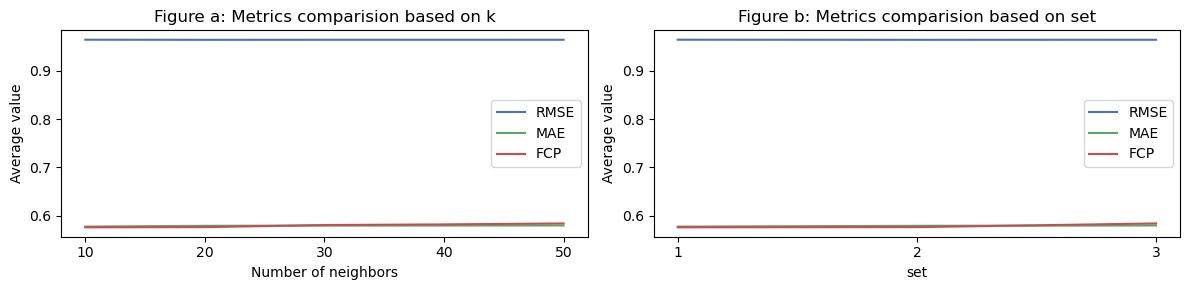

In [47]:
# CBF plot

plt.style.use("seaborn-v0_8-deep")
# Create structure for the big plot
fig, ax = plt.subplots(1,2, figsize=(12, 3))

## Subplot 1
subplot_func(grouped_results_cbf1, 'k', 0, 
             'a', 'Number of neighbors', 'Average value')
## Subplot 2
subplot_func(best_params_df_cbf_long, 'set', 1, 
             'b', 'set', 'Average value')


plt.tight_layout()  # Adjust the layout to prevent overlaps
plt.savefig('CBF_model.png', dpi=1200)
plt.show()

# Evaluating CBF with best k

In [36]:
from ContentBasedFiltering import ContentBasedFiltering 
from surprise.model_selection import train_test_split
from surprise import accuracy
from eval_metrics import precision_recall_at_k
from tabulate import tabulate

In [48]:
# create algorithms with best set parameters
cbf = ContentBasedFiltering(k=50)

# list of recommenders
algorithms = [cbf]

# name the recommenders
titles = ('CBF')

# split data into train and test set
trainset, testset = train_test_split(data, test_size=0.3, random_state=2024)

# create a blank list to store result
table = []    

# for loop to evaluate each algorithm
for algorithm in algorithms:
    start_time = time.time()  # start time
    algorithm.fit(trainset) 
    predictions = algorithm.test(testset)
    end_time = time.time()  # end time
    fit_time = round(end_time - start_time, 3)  # fit time
    
    rmse = round(accuracy.rmse(predictions, verbose=False), 3)
    mae = round(accuracy.mae(predictions, verbose=False), 3)
    fcp = round(accuracy.fcp(predictions, verbose=False), 3)
    p, r = precision_recall_at_k(predictions, k=5, threshold=4)
    precision = round(p, 3)
    recall = round(r, 3)
    
    table.append([str(algorithm).split(' ')[0].split('.')[-1],
                rmse,
                mae,
                fcp,
                precision,
                recall,
                fit_time])

# change column name
header = ['Recommenders',
          'Pred Accuracy [RMSE]',
          'Pred Accuracy [MAE]',
          'Ranking Quality [FCP]',
          'Precision',
          'Recall',
          'Training time [sec]']

# view the result table
print(tabulate(table, header, tablefmt='pipe'))

Computing Product Similarity Matrix...
| Recommenders          |   Pred Accuracy [RMSE] |   Pred Accuracy [MAE] |   Ranking Quality [FCP] |   Precision |   Recall |   Training time [sec] |
|:----------------------|-----------------------:|----------------------:|------------------------:|------------:|---------:|----------------------:|
| ContentBasedFiltering |                  0.991 |                 0.594 |                    0.61 |       0.709 |    0.716 |               103.996 |


# Predict missing ratings

In [4]:
# load data
full_df = pd.read_csv('data/full_data_cleaned.csv')
full_df.head(2)

,author_id,rating_x,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,...,price_usd_x,brand_id,ingredients,limited_edition,out_of_stock,sephora_exclusive,highlights,primary_category,num_rating,niche_product
0,1238130325,4,1.0,NaN,0,0,0,3/12/23,I love this lippy…it makes my lips soft and al...,Yumm,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0
1,27991208736,3,1.0,0.0,1,1,0,3/9/23,ive tried my friend’s a few times and it does ...,overrated/overpriced,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0


In [18]:
# select relevant columns
rating_df = full_df[['author_id', 'product_id', 'rating_x', 'submission_time']]

# rename columns
rating_df.columns = ['userID', 'itemID', 'rating', 'timeStamp']

# convert "character" to "dateTime"
rating_df.loc[:,'timeStamp'] = pd.to_datetime(rating_df['timeStamp'], format='mixed')
rating_df.head()

,userID,itemID,rating,timeStamp
0,1238130325,P420652,4,2023-03-12 00:00:00
1,27991208736,P420652,3,2023-03-09 00:00:00
2,9467587295,P420652,5,2023-03-07 00:00:00
3,12367701277,P420652,5,2023-03-05 00:00:00
4,33161024868,P420652,3,2023-03-04 00:00:00


In [19]:
# set up data
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_df.iloc[:, 0:3], reader)

In [20]:
# train set and anti set
trainset = data.build_full_trainset()
anti_set = data.build_full_trainset().build_anti_testset()
anti_set

[('1238130325', 'P7880', 4.375402357354598),
 ('1238130325', 'P218700', 4.375402357354598),
 ('1238130325', 'P248407', 4.375402357354598),
 ('1238130325', 'P269122', 4.375402357354598),
 ('1238130325', 'P417238', 4.375402357354598),
 ('1238130325', 'P450271', 4.375402357354598),
 ('1238130325', 'P427421', 4.375402357354598),
 ('1238130325', 'P411387', 4.375402357354598),
 ('1238130325', 'P441644', 4.375402357354598),
 ('1238130325', 'P427417', 4.375402357354598),
 ('1238130325', 'P309308', 4.375402357354598),
 ('1238130325', 'P411540', 4.375402357354598),
 ('1238130325', 'P471546', 4.375402357354598),
 ('1238130325', 'P248404', 4.375402357354598),
 ('1238130325', 'P443352', 4.375402357354598),
 ('1238130325', 'P423688', 4.375402357354598),
 ('1238130325', 'P421275', 4.375402357354598),
 ('1238130325', 'P297524', 4.375402357354598),
 ('1238130325', 'P429952', 4.375402357354598),
 ('1238130325', 'P480630', 4.375402357354598),
 ('1238130325', 'P126301', 4.375402357354598),
 ('1238130325',

In [8]:
# Define algorithm with best k
CBFrecommender = ContentBasedFiltering(k= 50)

#Train the model
CBFrecommender.fit(trainset)

Computing Product Similarity Matrix...


In [27]:
def get_top_n_recommendations(model, user_id, n=10):

    # Filter based on the first value of each item
    filtered_list = [item for item in anti_set if item[0] == user_id]
    predictions = model.test(filtered_list)

    # Convert to df
    predictions_df = pd.DataFrame(predictions)

    # Product info data
    product_info = full_df[['product_id', 'product_name_x', 'brand_name_x', 'price_usd_x',
                            'limited_edition','niche_product', 'out_of_stock']].drop_duplicates()
    
    # Merge data with product info
    predictions_df = predictions_df.merge(product_info, left_on = ['iid'], right_on = ['product_id'])
    
    # Filter out of stock products
    final_df = predictions_df[predictions_df['out_of_stock'] == 0].copy().sort_values(by='est', ascending=False)

    if len(final_df) > n:
        final_df_subset = final_df.head(n)  # Select the top n rows if the dataset has more than n rows
    else:
        final_df_subset = final_df  # Choose the whole dataset if it has n or fewer rows
    
    # Create a dataframe of top n recommendations with product information
    recommendations = []
    for product_id in final_df_subset['product_id']:
        product_info = full_df[full_df['product_id'] == product_id]
        recommendations.append({
            'product_name': product_info.iloc[0].product_name_x,
            'product_id': product_info.iloc[0].product_id,
            'brand': product_info.iloc[0].brand_name_x,
            'limited_edition': product_info.iloc[0].limited_edition,
            'price': product_info.iloc[0].price_usd_x,
            'rating': product_info.rating_x.mean(),
            'niche': product_info.iloc[0].niche_product
        })
    
    return pd.DataFrame(recommendations)

In [29]:
# Example usage
get_top_n_recommendations(CBFrecommender, '1238130325', 5)

,product_name,product_id,brand,limited_edition,price,rating,niche
0,Algae + Moringa Universal Hydrating Face Oil,P503991,MARA,0,72.00,4.879195,1
1,SuperSolutions 10% Urea Moisturizer Textured S...,P502756,The INKEY List,0,19.99,4.352941,1
2,Cannabis Sativa Seed Oil Herbal Concentrate (H...,P440937,Kiehl's Since 1851,0,55.00,4.086420,1
3,Retinol Anti-Aging Power Duo,P500856,Peace Out,1,48.00,4.583333,1
4,Symbright Brightening Moisturizer,P474972,The INKEY List,0,13.99,3.575758,1
